<a href="https://colab.research.google.com/github/Mrxiba/FDRL-SFC/blob/main/MIMO_multi_output0703.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Finish Single MIMO Here ==============================================================
=============================================================
do here

In [ ]:
!pip install torcheval

In [ ]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.7/364.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.3.0+cu121 and Flower 1.9.0


In [ ]:
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

norm_scaler_X1 = MinMaxScaler()
norm_scaler_X2 = MinMaxScaler()
norm_scaler_X3 = MinMaxScaler()

norm_scaler_Y1 = MinMaxScaler()
norm_scaler_Y2 = MinMaxScaler()
norm_scaler_Y3 = MinMaxScaler()

#NUM_CLIENTS = 2
BATCH_SIZE = batch_size = 50
ngpu = 0
dataroot_Inline = "/content/Inline_EC.csv"
#dataroot_Passive = "/content/Passive.csv"
#dataroot_vFW = "/content/vFW.csv"
#dataroot_test = "/content/vFW.csv"

class VNFDataset(Dataset):
    def __init__(self, root, xscaler, yscaler):
        self.df = pd.read_csv(root)
        self.data = self.df.to_numpy()
        labels=['RTT','EC']
        predictors = list(set(list(self.df.columns))-set(labels))
        self.df[predictors] = xscaler.fit_transform(self.df[predictors])
        self.df[labels] = yscaler.fit_transform(self.df[labels])#normalization
        self.df[predictors].dropna(axis=0)
        self.df[labels].dropna(axis=0)
        self.x = torch.tensor(self.df[predictors].values, dtype=torch.float32)
        self.y = torch.tensor(self.df[labels].values, dtype=torch.float32)
    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx,:]
    def __len__(self):
        return len(self.data)

def load_datasets():

    Inline_data = VNFDataset(dataroot_Inline, norm_scaler_X1, norm_scaler_Y1)

    #Passive_data = VNFDataset(dataroot_Passive)

    #vFW_data = VNFDataset(dataroot_vFW)

    testset = Inline_data

    # Split training set into 2
    datasets = [Inline_data]

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 30  # 30 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE,shuffle=True)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

In [ ]:
images, labels = next(iter(trainloaders[0]))

In [ ]:
images[49].shape

torch.Size([8])

In [ ]:
labels[29].shape

torch.Size([2])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(8, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 2)

        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.selu(self.layer1(x))
        x = self.selu(self.layer2(x))
        x = self.selu(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(8, 24),
#             nn.ReLU(),
#             nn.Linear(24, 12),
#             nn.ReLU(),
#             nn.Linear(12, 6),
#             nn.ReLU(),
#             nn.Linear(6, 2)
#         )

#     def forward(self, x):
#         x = self.linear_relu_stack(x)
#         return x

In [ ]:
Net62=Net()
print("The parameters: ", list(Net62.parameters()))

The parameters:  [Parameter containing:
tensor([[ 0.2148, -0.0834,  0.2780,  ...,  0.0862,  0.0877,  0.1809],
        [-0.1489,  0.2488,  0.3516,  ...,  0.3020, -0.0254, -0.0316],
        [ 0.2370, -0.0187,  0.3182,  ..., -0.2177, -0.2345,  0.2473],
        ...,
        [-0.0651,  0.1738,  0.3288,  ..., -0.1261, -0.1188,  0.1432],
        [ 0.0628, -0.0637,  0.3427,  ...,  0.3172, -0.3107,  0.0132],
        [ 0.0525, -0.2370, -0.2753,  ...,  0.1984,  0.1268, -0.1480]],
       requires_grad=True), Parameter containing:
tensor([-0.2156, -0.0342, -0.1508,  0.1966,  0.2920,  0.3506, -0.0266, -0.3106,
         0.3482,  0.1286, -0.3487, -0.0986, -0.1131, -0.1730,  0.2960, -0.2046,
         0.1577, -0.0094,  0.1017,  0.0868,  0.0093, -0.0419, -0.0739,  0.0641,
         0.0430,  0.1747,  0.2231,  0.0836,  0.1024,  0.2246, -0.2259, -0.1866,
         0.1637, -0.0712, -0.1066, -0.1816,  0.1478,  0.3093,  0.0861,  0.1947,
        -0.3320, -0.1022,  0.2149, -0.3373, -0.2870, -0.1546, -0.1790,  0.03

In [ ]:
import torch
from torcheval.metrics import MeanSquaredError
from torcheval.metrics import R2Score


def train(net, trainloader, epochs: int,verbose=True):
    """Train the network on the training set."""
    criterion = torch.nn.MSELoss() #MSE
    L1 = torch.nn.L1Loss() #MAE
    metricR2 = R2Score()#R2
    optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
    net.train()
    for epoch in range(epochs):
      epoch_loss, epoch_loss2, epoch_loss3 = 0.0, 0.0, 0.0
      for images, labels in trainloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(images)
        labels = labels.float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Metrics
        epoch_loss = L1(outputs, labels)#MAE loss
        epoch_loss2 = torch.sqrt(loss) #rMSE loss
        epoch_loss3 = metricR2.update(outputs, labels).compute().item()
      if verbose:
        print(f"Epoch {epoch+1}: train MAE {epoch_loss}, train RMSE {epoch_loss2}, train R2 {epoch_loss3}")
    #return epoch_loss2#RMSE


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    MAE,RMSE, R2 = 0.0, 0.0, 0.0
    net.eval()
    L1 = torch.nn.L1Loss() #MAE
    metricMSE = MeanSquaredError()#MSE
    metricR2 = R2Score()#R2
    with torch.no_grad():
        for images, labels in testloader:
          images, labels = images.to(DEVICE), labels.to(DEVICE)
          outputs = net(images)
          labels = labels.float()
          # Metrics
          MAE = L1(outputs, labels)
          RMSE = torch.sqrt(metricMSE.update(outputs, labels).compute()).item()
          R2 = metricR2.update(outputs, labels).compute().item()

    return MAE, RMSE, R2

In [ ]:
def test_MIMO(net, testloader):
    """Evaluate the network on the entire test set."""
    MAE_EC,RMSE_EC, R2_EC = 0.0, 0.0, 0.0
    MAE_RTT,RMSE_RTT, R2_RTT = 0.0, 0.0, 0.0
    net.eval()
    L1 = torch.nn.L1Loss() #MAE
    metricMSE = MeanSquaredError()#MSE
    metricR2 = R2Score()#R2
    with torch.no_grad():
        for images, labels in testloader:
          images, labels = images.to(DEVICE), labels.to(DEVICE)
          outputs = net(images)
          labels = labels.float()

          # Metrics
          MAE_RTT = L1(outputs[:,0], labels[:,0])
          RMSE_RTT = torch.sqrt(metricMSE.update(outputs[:,0], labels[:,0]).compute()).item()
          R2_RTT = metricR2.update(outputs[:,0], labels[:,0]).compute().item()

          MAE_EC = L1(outputs[:,1], labels[:,1])
          RMSE_EC = torch.sqrt(metricMSE.update(outputs[:,1], labels[:,1]).compute()).item()
          R2_EC = metricR2.update(outputs[:,1], labels[:,1]).compute().item()

    return MAE_RTT, RMSE_RTT, R2_RTT, MAE_EC, RMSE_EC, R2_EC

<>:18: DeprecationWarning: invalid escape sequence '\ '


Epoch 1: train MAE 0.1244489774107933, train RMSE 0.22068175673484802, train R2 0.5640550255775452
Epoch 1: val all MAE 0.14498165249824524, val all RMSE 0.2314576506614685, val all R2 0.5391982793807983
Epoch 1: val RTT MAE 0.14406666159629822, val RTT RMSE 0.23029710352420807, val RTT R2 0.551001787185669
Epoch 1: val EC MAE 0.14589665830135345, val EC RMSE 0.2314576506614685, val EC R2 0.539416491985321
Epoch 1: train MAE 0.15929840505123138, train RMSE 0.21839351952075958, train R2 0.6949959993362427
Epoch 2: val all MAE 0.1375584751367569, val all RMSE 0.2138204425573349, val all R2 0.6069122552871704
Epoch 2: val RTT MAE 0.1384028196334839, val RTT RMSE 0.21558013558387756, val RTT R2 0.6065542101860046
Epoch 2: val EC MAE 0.1367141306400299, val EC RMSE 0.2138204425573349, val EC R2 0.6069356203079224
Epoch 1: train MAE 0.15875084698200226, train RMSE 0.20366011559963226, train R2 0.7138696908950806
Epoch 3: val all MAE 0.1436854898929596, val all RMSE 0.2095990926027298, val al

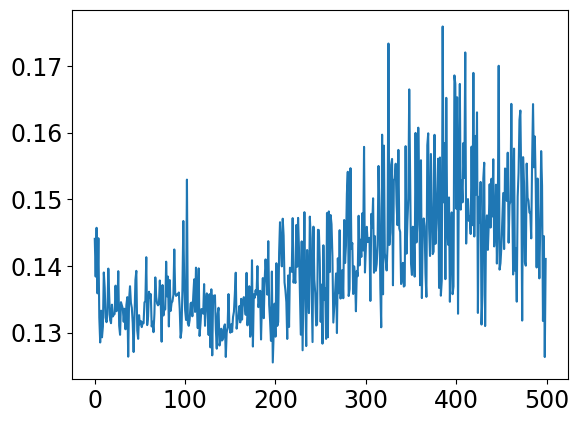

In [ ]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)
loss_values=[]
Loss_RTT = []
for epoch in range(500):
    #train_RMSELOSS = train(net, trainloader, 1)
    train(net, trainloader, 1)
    loss_1, loss_2, loss_3 = test(net, valloader) #MAE, RMSE, R2
    print(f"Epoch {epoch+1}: val all MAE {loss_1}, val all RMSE {loss_2}, val all R2 {loss_3}")
    #loss_values.append(train_RMSELOSS.detach().numpy())
    MAE_RTT, RMSE_RTT, R2_RTT, MAE_EC, RMSE_EC, R2_EC = test_MIMO(net, valloader)
    print(f"Epoch {epoch+1}: val RTT MAE {MAE_RTT}, val RTT RMSE {RMSE_RTT}, val RTT R2 {R2_RTT}")
    print(f"Epoch {epoch+1}: val EC MAE {MAE_EC}, val EC RMSE {RMSE_EC}, val EC R2 {R2_EC}")
    Loss_RTT.append(MAE_RTT.detach().numpy())

MAE_e, RMSE_e, R2_e = test(net, testloader)
print(f"Final test set performance:\n \ testMAE {MAE_e}\n \ testRMSE {RMSE_e}\n \ testR2 {R2_e}")
t_MAE_RTT, t_RMSE_RTT, t_R2_RTT, t_MAE_EC, t_RMSE_EC, t_R2_EC, = test_MIMO(net, testloader)
print(f"Final test set RTT performance:\n \ test_RTT_MAE {t_MAE_RTT}\n \ test_RTT_RMSE {t_RMSE_RTT}\n \ test_RTT_R2 {t_R2_RTT}")
print(f"Final test set EC performance:\n \ test_EC_MAE {t_MAE_EC}\n \ test_EC_RMSE {t_RMSE_EC}\n \ test_EC_R2 {t_R2_EC}")
plt.plot(Loss_RTT)
plt.show()
#print(f"Final test set CPUUTP performance:\n\test_CPUUTP_MAEloss {t_MAE_CPUUTP}\n\test_CPUUTP_RMSEloss {t_RMSE_CPUUTP}\n\test_CPUUTP_R2loss {t_R2_CPUUTP}")

# **Test visulation**

array([[  0.5709222 ,  62.16438   ],
       [  0.4639184 ,  50.49815   ],
       [  0.5994593 ,  64.38483   ],
       [  2.4238868 , 259.13922   ],
       [  1.0214988 , 111.98675   ],
       [  0.4630191 ,  49.746113  ],
       [  0.71941394,  79.1556    ],
       [  0.6201812 ,  67.55486   ],
       [  2.5182197 , 269.01077   ],
       [  0.38812408,  42.63289   ],
       [  0.53286093,  58.472656  ],
       [  2.4969485 , 265.1946    ],
       [  0.6540813 ,  70.540855  ],
       [  0.5672956 ,  62.533745  ],
       [  0.6613523 ,  72.34894   ],
       [  0.5589651 ,  60.628788  ],
       [  0.44413438,  48.32552   ],
       [  0.46155918,  50.059147  ],
       [  0.434396  ,  46.305874  ],
       [  0.6170285 ,  66.22259   ],
       [  2.0269697 , 219.25555   ],
       [  0.4574711 ,  49.021397  ],
       [  2.4231093 , 255.99991   ],
       [  0.6134801 ,  66.85272   ],
       [  0.59193957,  64.20806   ],
       [  0.5242845 ,  56.335537  ],
       [  0.4694441 ,  50.758694  ],
 

[[  2.7492545  295.14056   ]
 [  0.59730977  65.14227   ]
 [  1.0925407  117.99832   ]
 [  0.65792364  71.01462   ]
 [  0.57307035  62.504578  ]
 [  1.0775089  115.59561   ]
 [  2.3695352  254.207     ]
 [  0.42752016  46.33469   ]
 [  2.2260556  238.39523   ]
 [  2.3350492  249.35199   ]
 [  0.8150292   88.514114  ]
 [  2.2187197  236.67015   ]
 [  0.4089864   44.018066  ]
 [  0.6308518   66.55892   ]
 [  0.7762718   87.38942   ]
 [  2.3368342  249.60672   ]
 [  2.3722084  254.57507   ]
 [  1.9723343  212.33409   ]
 [  0.44879314  47.654057  ]
 [  0.6366619   67.411835  ]
 [  1.1058218  117.59659   ]
 [  0.40753     44.468884  ]
 [  0.44923994  48.11941   ]
 [  0.71830344  78.23313   ]
 [  0.8226202   89.42375   ]
 [  0.726478    77.63546   ]
 [  2.1818497  233.58792   ]
 [  2.4799533  265.642     ]
 [  2.297892   244.65048   ]
 [  2.3084912  245.68571   ]
 [  0.537813    58.08212   ]
 [  0.35453823  38.25572   ]
 [  0.69012153  74.59707   ]
 [  0.48484355  52.72216   ]
 [  0.49244452

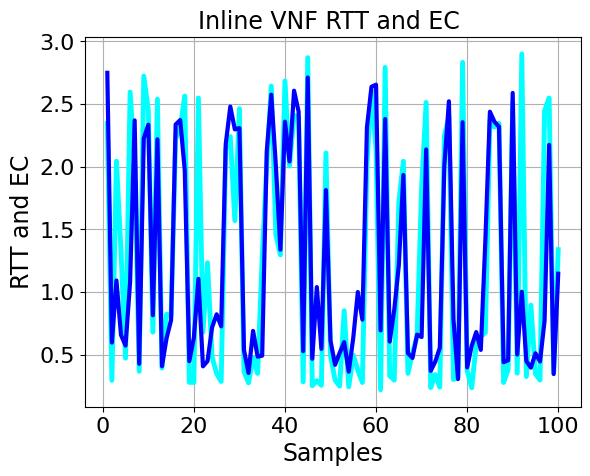

In [ ]:
################################
### Visualizations ###
################################
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

test_domain = "/content/Inline_EC.csv"
dfs = pd.read_csv(test_domain)
dfs = dfs.sample(frac = 1)
labels=['RTT','EC']#CPU MEM LINK
predictors = list(set(list(dfs.columns))-set(labels))
norm_Xs = norm_scaler_X1.fit_transform(dfs[predictors])
Y_GT = dfs[labels].values
y_test = Y_GT[0:100,:]
X_test = norm_Xs[0:100,:]
y_pred = net(torch.tensor(X_test, dtype=torch.float32).to(DEVICE))
y_pred = y_pred.detach().numpy()
y_pred = norm_scaler_Y1.inverse_transform(y_pred)
print(y_pred)

################################
X_axis = np.arange(1,101,1)
X_axis = X_axis.reshape((len(X_axis),1))
################################

y_RTT = y_test[:,0]
y_EC = y_test[:,1]


y_net_pred_RTT = y_pred[:,0]
y_net_pred_EC =  y_pred[:,1]

plt.plot(X_axis, y_RTT,color="cyan",label='Target Ground Truth',lw =3.5)
#plt.plot(X_axis, y_EC, color="orange",label='FTCA-MLP Predicted',lw=3.5)

plt.plot(X_axis, y_net_pred_RTT, color="blue",label='RTT Predicted',lw=3.0)
#plt.plot(X_axis, y_net_pred_EC, color="green",label='EC Predicted',lw=3.0)

# plt.plot(X_axis, y_svr_pred, color="green",label='FTCA-SVR Predicted',lw=2.5)
# #plt.plot(X_axis, svr_regressor_2.predict(Xt),color="green",label='SVR Predicted',lw=1, linestyle = 'dotted')

# plt.plot(X_axis, y_nn_pred, color="black",label='FTCA-MLP Predicted',lw = 2)
# #plt.plot(X_axis, tree_regressor_2.predict(Xt), color="black",label='DT Predicted',linestyle = 'dotted')

# plt.plot(X_axis, y_RF_pred, color="red",label='FTCA-RF Predicted',lw=1.5)


plt.rcParams['font.size'] = 17
plt.title("Inline VNF RTT and EC ",fontsize= 17)
plt.xlabel("Samples",fontsize= 17)
plt.ylabel("RTT and EC",fontsize= 17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

# plt.legend(loc='best')
# plt.savefig('Regression compare_CPU.pdf', bbox_inches='tight')
plt.show()


======================================================= Code end here

Ignore the underneath context
# **Ignore the underneath**

In [ ]:
L1 = torch.nn.L1Loss()
metricMSE = MeanSquaredError()#MSE
metricR2 = R2Score()#R2


MAE_CPUUTP = L1(outputs[:,0], labels[:,0])
MSE_CPUUTP = metricMSE.update(outputs[:,0], labels[:,0]).compute().item()
R2_CPUUTP = metricR2.update(outputs[:,0], labels[:,0]).compute().item()

print(f"Final test set metrics:\n \\ pytorchMAEloss {MAE_CPUUTP}\n\\ pytorchMSEloss {MSE_CPUUTP}\n\\ pytorchR2 {R2_CPUUTP}")

Final test set metrics:
 \ pytorchMAEloss 0.052874356508255005
\ pytorchMSEloss 0.006991443689912558
\ pytorchR2 0.4459463953971863


In [ ]:
a = outputs[:,0] #c
b= labels[:,0] #d

In [ ]:
f= torch.sqrt(a)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import sklearn.metrics as metrics
mae_poly = metrics.mean_absolute_error(d, c)
mse_poly = metrics.mean_squared_error(d, c)
rmse_poly = np.sqrt(mse_poly)
r2_poly = metrics.r2_score(d,c)
print(f"MAE: {mae_poly}")
print(f"MSE: {mse_poly}")
print(f"RMSE: {rmse_poly}")
print(f"R2: {r2_poly}")

MAE: 0.052874000000000004
MSE: 0.006990763
RMSE: 0.08361078279743588
R2: 0.44599349962667323
